## Random GRNs

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({"font.size": 16})

import helper

/Users/csengepetak/Documents/GitHub/CA_GRN2/helper.py:61: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/Users/csengepetak/Documents/GitHub/CA_GRN2/helper.py:82: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


### Random GRNs

In [23]:
#Parameters
pop_size = 1000
grn_size = 10
num_cells = 22
dev_steps = 22
geneid = 1

rule = 90
seed_int = 1238860 #1024 #69904,149796,4147842,1238860,2481300

pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
targets, phenos, fitnesses = helper.get_pop_TPF(pop, pop_size, num_cells, grn_size, dev_steps, geneid, rule, seed_int)

#pickle.dump(phenos, open("random_phenos.p", "wb" ) )
#phenos = pickle.load(open("random_phenos.p", "rb"))

In [24]:
def global_devel(seed, GRN):
    N = seed.shape[0]
    history = np.empty((N+1,N), dtype=seed.dtype)
    history[0] = seed
    for i in range(1,N+1):
        matmul = GRN.dot(history[i-1])
        history[i] = 1 / (1 + np.exp(-matmul)) #same as helper.sigmoid(matmul, 1, 0), njit problems with different input shape
    return history

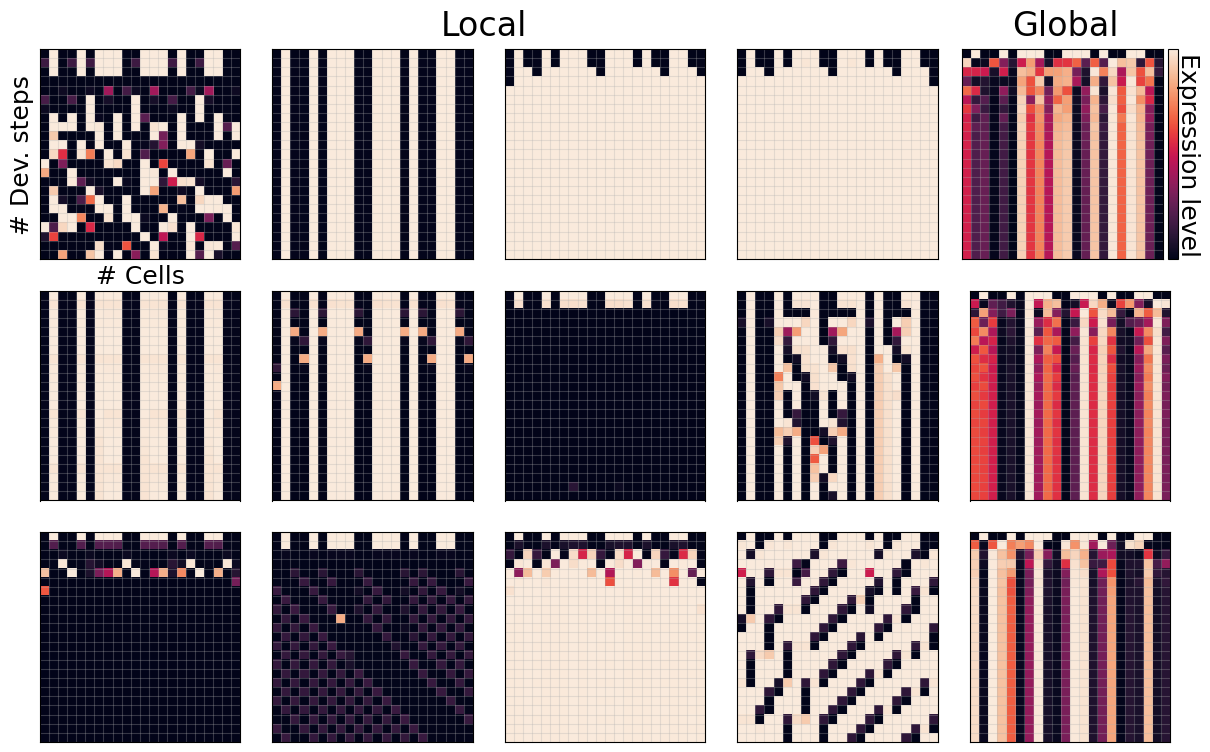

In [25]:
ncols = 5
nrows = 3
scale = 3
fig, axs = plt.subplots(figsize=(ncols * scale, nrows * scale), ncols=ncols, nrows=nrows)

l = 0
for i, ax in enumerate(axs.flatten()):

    if i % ncols == ncols - 1:
        GRN = np.random.randn(22, 22)
        pheno = global_devel(np.array(helper.seedID2string(seed_int, num_cells)).astype(np.float64), GRN)
        im = helper.imshow_ca(pheno, ax=ax)
        if i == ncols - 1:
            #ax.set_title("Global")
            ax.text(5, -2, 'Global', fontsize=24)
            # https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax, ticks=[])
            #cbar.ax.set_yticklabels(['0.0', '0.5', '1.0'])
            cbar.set_label("Expression level", rotation=270, labelpad=16, fontsize=18)
    elif i == 0:
        im = helper.imshow_ca(phenos[l], ax=ax)
        l+= 1
        ax.set_xlabel("# Cells", fontsize=18)
        #ax.xaxis.set_label_position("top")
        ax.set_ylabel("# Dev. steps", fontsize=18)
        #ax.set_title("Local")
    elif i == 1:
        im = helper.imshow_ca(phenos[l], ax=ax)
        l+= 1
        ax.text(18, -2, 'Local', fontsize=24)
    else:
        im = helper.imshow_ca(phenos[l], ax=ax)
        l+= 1

plt.subplots_adjust(wspace=0, hspace=0.15)
#plt.tight_layout()
#plt.savefig("figs/random_pheno_distribution.png")
plt.show()

In [26]:
rules=[54,102,94,150,90,30,50,254,62,110] #list(range(0,256))

fits=[]
for rule in rules:
    targets, calc_phenos, calc_fitnesses = helper.get_pop_TPF(pop, pop_size, num_cells, grn_size, dev_steps, geneid, rule, seed_int)
    fits.append(calc_fitnesses)

#pickle.dump(fits, open("random_fits_all256.p", "wb" ) )
#fits = pickle.load(open("random_fits.p", "rb"))

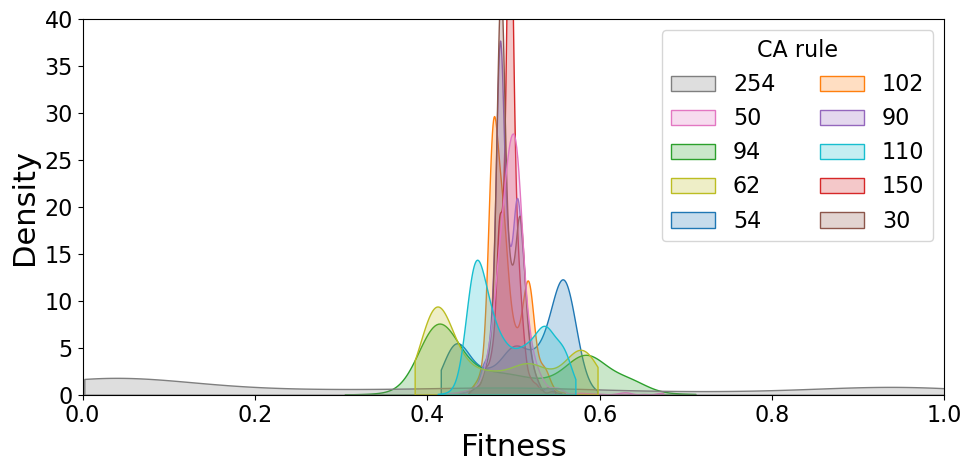

In [27]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rules=[54,102,94,150,90,30,50,254,62,110]
rule_order=[254,50,94,62,54,102,90,110,150,30]
order=[]
for i in rule_order:
    j=np.where(np.array(rules) == i)[0][0]
    order.append(j)

plt.figure(figsize=(10, 5)) 
for i,f in enumerate(fits):
    sns.kdeplot(f,fill=True,label=rules[i],clip=(min(f), max(f)))

#plt.legend(title="CA rule",ncol=2,loc="upper left")
handles, labels = plt.gca().get_legend_handles_labels()

# Reorder handles and labels
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]

plt.legend(handles, labels,title="CA rule",ncol=2,loc="upper right")

plt.xlabel("Fitness",fontsize=22)
plt.ylabel("Density",fontsize=22)
plt.xlim(0,1)
plt.ylim(0,40)
plt.tight_layout()
plt.show()
#plt.savefig("figs/random_grn_fitness.png")

In [107]:
worst= -num_cells*dev_steps
start_pattern = np.array(helper.seedID2string(seed_int, num_cells)).astype(np.float64)
fits=[]
for rule in rules:
    target = helper.rule2targets_wrapped_wstart(int(rule), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
    phenos = []
    for p in range(pop_size):
        GRN = np.random.randn(grn_size, grn_size) #4 random GRNs
        phenos.append(global_devel(start_pattern, GRN))
    prefitnesses = helper.fitness_function_ca(phenos, target)
    fitnesses=1-(prefitnesses/worst) #0-1 scaling
    fits.append(fitnesses)


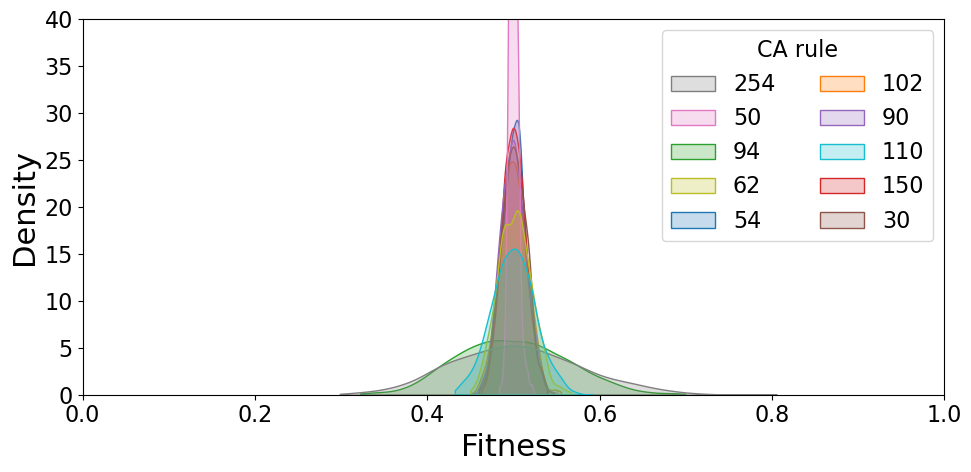

In [108]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

rules=[54,102,94,150,90,30,50,254,62,110]
rule_order=[254,50,94,62,54,102,90,110,150,30]
order=[]
for i in rule_order:
    j=np.where(np.array(rules) == i)[0][0]
    order.append(j)

plt.figure(figsize=(10, 5)) 
for i,f in enumerate(fits):
    sns.kdeplot(f,fill=True,label=rules[i],clip=(min(f), max(f)))

#plt.legend(title="CA rule",ncol=2,loc="upper left")
handles, labels = plt.gca().get_legend_handles_labels()

# Reorder handles and labels
handles = [handles[i] for i in order]
labels = [labels[i] for i in order]

plt.legend(handles, labels,title="CA rule",ncol=2,loc="upper right")

plt.xlabel("Fitness",fontsize=22)
plt.ylabel("Density",fontsize=22)
plt.xlim(0,1)
plt.ylim(0,40)
plt.tight_layout()
plt.show()
#plt.savefig("figs/random_grn_fitness.png")

#### Where it is in the fitness landscape?

In [28]:
#Parameters
pop_size = 1000
grn_size = 10
num_cells = 22
dev_steps = 22
geneid = 1


In [33]:
seed_int = 1024 #1024 #69904,149796,4147842,1238860,2481300
rule = 30

pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
targets, phenos, fitnesses = helper.get_pop_TPF(pop, pop_size, num_cells, grn_size, dev_steps, geneid, rule, seed_int)

In [34]:
selection_prop = 0.1
mut_rate = 0.1
mut_size = 0.5

selection_size=int(pop_size*selection_prop) #100 are selected to reproduce
num_child = 100#int(pop_size / selection_size) - 1 #9 kids for each selected
tot_children = num_child * selection_size #900 kids in total
num_genes_mutate = int((grn_size + 2) * grn_size * tot_children * mut_rate) #mut_rate percent of all genes across all kids mutated, so 10%
mutations = np.random.randn(num_genes_mutate) * mut_size #generate num_genes_mutate mutations, scaled by mut_size

children = np.tile(pop, (num_child, 1, 1))

x, y, z = children.shape
#children is a 3D object, 2d genome for N individuals, find num_genes_mutate points in this object to mutate
xs = np.random.choice(x, size=num_genes_mutate) 
ys = np.random.choice(y, size=num_genes_mutate)
zs = np.random.choice(z, size=num_genes_mutate)
children[xs, ys, zs] = children[xs, ys, zs] + mutations

reshaped=np.reshape(children, (num_child, pop_size, grn_size+2, grn_size))
reshaped=np.transpose(reshaped, [1, 0, 2, 3])
reshaped.shape
#reshaped[0] is a list of 9 elements, all kids of 1 parent

(1000, 100, 12, 10)

In [35]:
_, _, pop_fitnesses = helper.get_pop_TPF(pop, pop_size, num_cells, grn_size, dev_steps, geneid, rule, seed_int)
pos_perc=[]
for idx, c in enumerate(reshaped):
    _, _, kid_fitnesses = helper.get_pop_TPF(c, num_child, num_cells, grn_size, dev_steps, geneid, rule, seed_int)
    pos_perc.append(len(np.where(kid_fitnesses > pop_fitnesses[idx])[0])/len(kid_fitnesses))

Text(0.5, 1.0, 'Rule: 30, seed: 1024')

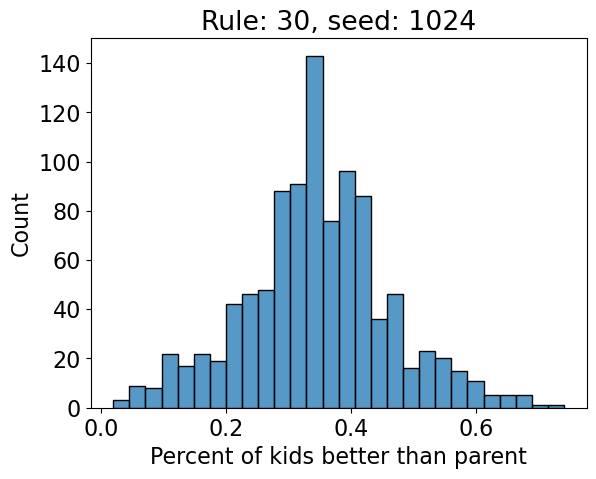

In [36]:
#sns.kdeplot(pop_fitnesses)
sns.histplot(pos_perc)
plt.xlabel("Percent of kids better than parent")
plt.title(f'Rule: {rule}, seed: {seed_int}')